In [1]:
# just using the bounding box


#### get png and json filepaths

import glob
import os
import re
from PIL import Image

path = "/Users/dk/Documents.nosync/msc-project/boundingbox/hubble_random_10k/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)

## get the translations (YVALS) from the json files

import os
import json
import numpy as np

translations = []
for json_f in json_files:
    with open(json_f) as f: translations.append(json.load(f)['translation'])

translations = np.array(translations, dtype=np.float32)
y_vals = translations


# extract dimensions (XVALS) from the data


def model_dimensions(img_np:np.ndarray):

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    ymin, ymax = np.min(y), np.max(y)
    xmin, xmax = np.min(x), np.max(x)
    height = ymax - ymin
    width = xmax - xmin
    return height, width, ymin, ymax, xmin, xmax


dimensions = []
for png_f in png_files:
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    dimensions.append(model_dimensions(img_np))
dimensions = np.array(dimensions, dtype=np.float32)
xvals = dimensions


# CHOOSE TRAINING AND TESTING INDICES

import random
random.seed(42)
data_percent = 0.7
n_pts_to_train = int(data_percent*len(xvals))

n = len(xvals[:n_pts_to_train])
n_train = int(data_percent*n)
n_test = n - n_train
print(n, n_train, n_test)

indices = list(range(n))
random.shuffle(indices)
train_indices = indices[:n_train]
test_indices = indices[n_train:]


7053 4937 2116


l2 score on test, Extra trees 4.977315391143745


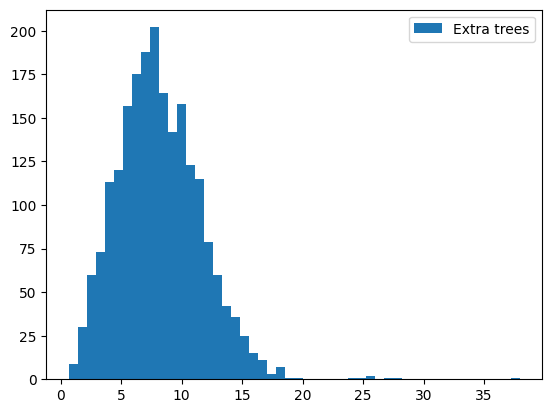

l2 score on test, K-nn 5.15241


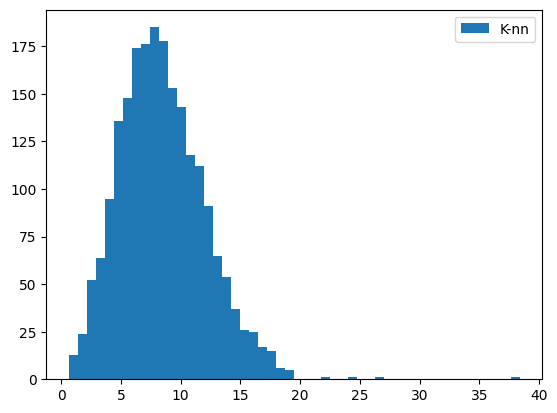

l2 score on test, Ridge 4.789957615092923


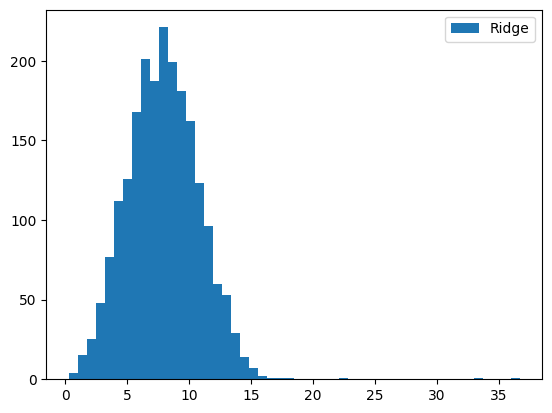

l2 score on test, Linear Regression 4.7894754


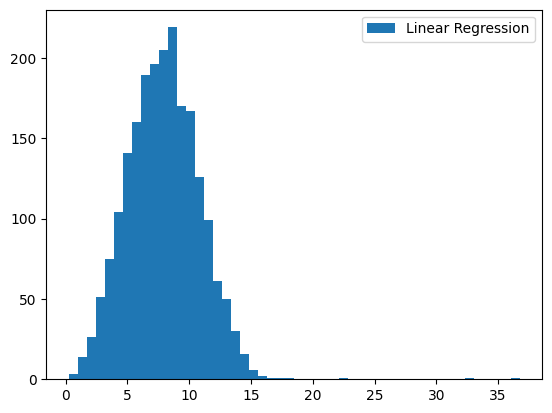

l2 score on test, Lasso Linear_0.01 4.789952


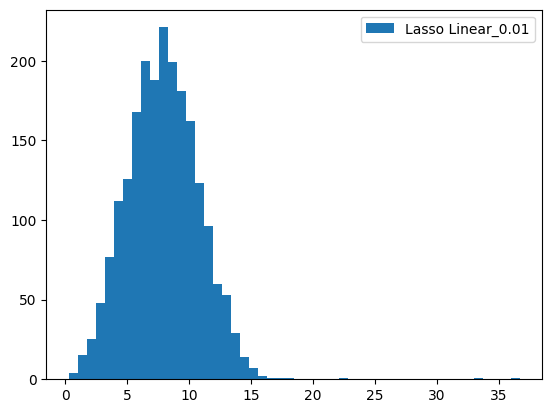

l2 score on test, Lasso Linear_0.1 4.789874


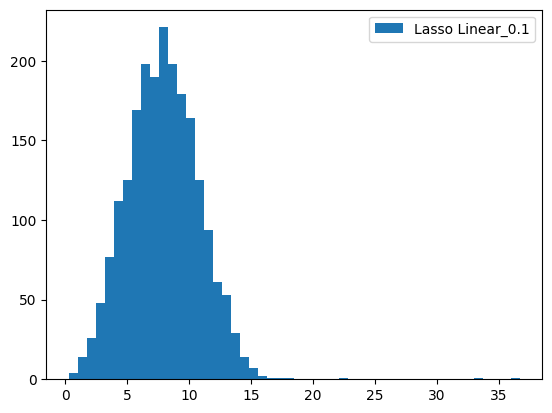

l2 score on test, Lasso Linear_0.5 4.789527


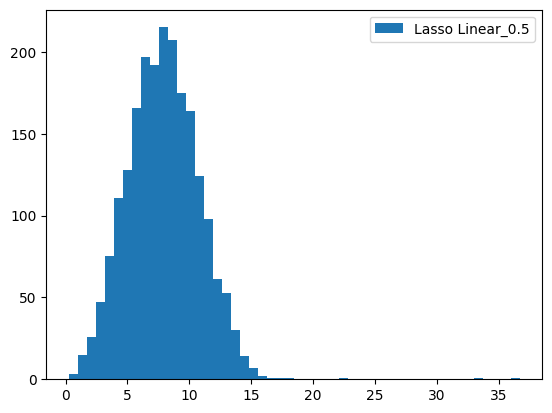

In [3]:
# other
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
import sklearn
import matplotlib.pyplot as plt

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}

def l2(truth, pred):
    return np.linalg.norm(truth-pred, axis=1)

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(xvals[train_indices], y_vals[train_indices])
    y_test_predict[name] = estimator.predict(xvals[test_indices])
    print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals[test_indices], y_test_predict[name], squared=False))
    plt.hist(l2(y_vals[test_indices], y_test_predict[name]), bins=50, alpha=1, label=name)
    plt.legend()
    plt.show()
# 

In [ ]:
def l2(truth, pred):
    return np.linalg.norm(truth-pred, axis=1)

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(xvals[train_indices], y_vals[train_indices])
    y_test_predict[name] = estimator.predict(xvals[test_indices])
    print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals[test_indices], y_test_predict[name], squared=False))
    plt.hist(l2(y_vals[test_indices], y_test_predict[name]), bins=50, alpha=1, label=name)
    plt.legend()
    plt.show()

In [6]:

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt


# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}

def l2(truth, pred):
    return np.linalg.norm(truth-pred, axis=1)

estimator = ESTIMATORS['Extra trees']
estimator.fit(xvals[train_indices], y_vals[train_indices])
y_test_predict = estimator.predict(xvals)


# quartiles
l2_scores = l2(y_vals[test_indices], y_test_predict[test_indices])
print(np.quantile(l2_scores, [0,0.25,0.5,0.75,1]))
print(l2_scores.mean())


[ 0.64896719  5.7225694   7.84917933 10.32996303 37.93822627]
8.156644782256953


l2 score on test, Linear Regression 4.7894754


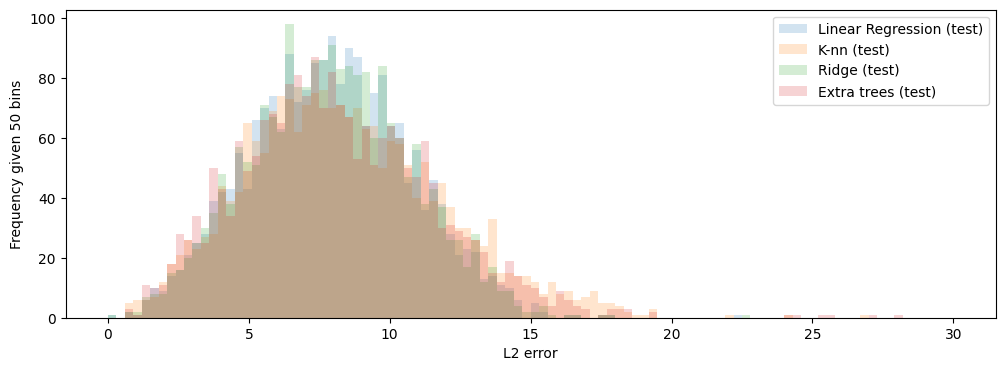

[ 0.64896719  5.7225694   7.84917933 10.32996303 37.93822627]
8.156644782256953


In [8]:

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt


# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}

def l2(truth, pred):
    return np.linalg.norm(truth-pred, axis=1)


plt.figure(figsize=(12,4))

########## DEFINE BINS

# Define the desired bin edges (minimum and maximum values)
min_bin = 0
max_bin = 30
bin_width = 0.3  # Adjust this value as needed

# Calculate the number of bins based on the range and bin width
num_bins = int((max_bin - min_bin) / bin_width)




name = 'Linear Regression'
estimator = ESTIMATORS[name]
estimator.fit(xvals[train_indices], y_vals[train_indices])
y_test_predict = estimator.predict(xvals)

print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals[test_indices], y_test_predict[test_indices], squared=False))
plt.hist(l2(y_vals[test_indices], y_test_predict[test_indices]), bins=num_bins, range=(min_bin, max_bin), alpha=0.2, label=f'{name} (test)');

name = 'K-nn'
estimator = ESTIMATORS[name]
estimator.fit(xvals[train_indices], y_vals[train_indices])
y_test_predict = estimator.predict(xvals)
plt.hist(l2(y_vals[test_indices], y_test_predict[test_indices]), bins=num_bins, range=(min_bin, max_bin), alpha=0.2, label=f'{name} (test)');

name = 'Ridge'
estimator = ESTIMATORS[name]
estimator.fit(xvals[train_indices], y_vals[train_indices])
y_test_predict = estimator.predict(xvals)
plt.hist(l2(y_vals[test_indices], y_test_predict[test_indices]), bins=num_bins, range=(min_bin, max_bin), alpha=0.2, label=f'{name} (test)');

name = 'Extra trees'
estimator = ESTIMATORS[name]
estimator.fit(xvals[train_indices], y_vals[train_indices])
y_test_predict = estimator.predict(xvals)
plt.hist(l2(y_vals[test_indices], y_test_predict[test_indices]), bins=num_bins, range=(min_bin, max_bin), alpha=0.2, label=f'{name} (test)');


plt.xlabel('L2 error')
plt.ylabel('Frequency given 50 bins')
plt.legend()
plt.show()

# quartiles
l2_scores = l2(y_vals[test_indices], y_test_predict[test_indices])
print(np.quantile(l2_scores, [0,0.25,0.5,0.75,1]))
print(l2_scores.mean())
